### 50.039 Image Segmentation Model

In [ ]:
# for google colab
import sys
on_colab = 'google.colab' in sys.modules
if on_colab:
  !pip install icecream

In [ ]:
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from PIL import Image
from pathlib import Path

import torch.nn as nn
from icecream import ic

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.transforms import v2

import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
if on_colab:
  dataset_path = '/content/drive/MyDrive/50.039_DL_Project/dataset'
  !ls $dataset_path
else:
  dataset_path = 'dataset'

Dataset_BUSI_with_GT


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

from sklearn.model_selection import train_test_split

class BusiDataset(VisionDataset):
    def __init__(self, root, transforms=None, transform=None, target_transform=None, split="train"):
        super().__init__(root, transforms, transform, target_transform)
        self.root = Path(root)
        mask_paths = list(root.rglob("*_mask.png"))
        train_paths, tmp_paths = train_test_split(mask_paths, test_size=0.2, random_state=0)
        if split != "train":
          val_paths, test_paths = train_test_split(tmp_paths, test_size=0.5, random_state=0)
          self.mask_paths = val_paths if split == "val" else test_paths
        else:
          self.mask_paths = train_paths

    def __getitem__(self, idx):
        mask_path = self.mask_paths[idx]
        img_path = Path(str(mask_path)[:-9] + ".png")
        mask = Image.open(mask_path)
        img = Image.open(img_path) ## TODO: make the image mono to reduct compute cost

        if self.transforms is not None:
            img, mask = self.transforms(img, mask)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            mask = self.target_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.mask_paths)

## Original UNet
- Source Code: Aladdin Person, Machine-Learning-Collection, (2023), GitHub repository, https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/model.py

In [ ]:
import torchvision.transforms.functional as TF

class DoubleConv2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(p=0.1),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(p=0.1)
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[32, 64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv2(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv2(feature*2, feature))

        self.bottleneck = DoubleConv2(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
model = UNET().to(device)
print(model)

SimpleUNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Dropout2d(p=0.3, inplace=False)
      )
    )
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(

In [ ]:
train_transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    # v2.RandomRotate((-90, 90)),
    v2.ColorJitter(brightness=0.2, # Random adjustments
                   contrast=0.2,
                   saturation=0.2,
                   hue=0.1),
    v2.RandomResizedCrop(size=(512, 512), antialias=True), ## By right suppose to be 500x500, but 512 just seems like a nicer number
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.Resize(size=(512, 512), antialias=True),
    v2.ToDtype(torch.float32, scale=True)
])

# Splitting into train, test and validation sets
train_dataset = BusiDataset(Path(dataset_path) / "Dataset_BUSI_with_GT", transforms=train_transforms, split = "train")
val_dataset = BusiDataset(Path(dataset_path) / "Dataset_BUSI_with_GT", transforms=val_transforms, split = "val")
test_dataset = BusiDataset(Path(dataset_path) / "Dataset_BUSI_with_GT", transforms=val_transforms, split = "test")

ic(len(train_dataset), len(val_dataset), len(test_dataset))

# train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
# val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

ic| len(train_dataset): 624
    len(val_dataset): 78
    len(test_dataset): 78


(624, 78, 78)

In [ ]:
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
import random
import math

class ThreadDataLoader():
  def __init__(self, dataset, batch_size = 1, shuffle = False, num_workers = 2, look_ahead = 2):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.num_workers = num_workers
    self.look_ahead = look_ahead

  def __getitem__(self, idx):
    return self.dataset[idx]

  def __len__(self):
    return math.ceil(len(self.dataset) / self.batch_size)

  def __iter__(self):
    executor = PoolExecutor(max_workers=self.num_workers)
    idxs = list(range(len(self.dataset)))
    if self.shuffle:
      random.shuffle(idxs)
    look_ahead = self.look_ahead * max(self.batch_size, self.num_workers)
    futures = {i: executor.submit(ThreadDataLoader.__getitem__, self, i) for i in idxs[:look_ahead]}
    collated_arr = []
    for i, idx in enumerate(idxs):
      data = futures[idx].result()
      del futures[idx]
      if i + look_ahead < len(idxs):
        futures[idxs[i + look_ahead]] = executor.submit(ThreadDataLoader.__getitem__, self, idxs[i + look_ahead])
      collated_arr.append(data)
      collated_batch = []
      if len(collated_arr) == self.batch_size:
          collated_batch = [torch.stack(data) for data in zip(*collated_arr)]
          yield collated_batch
          collated_arr = []
    if len(collated_arr) > 0:
      collated_batch = [torch.stack(data) for data in zip(*collated_arr)]
      yield collated_batch

train_dataloader = ThreadDataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = ThreadDataLoader(val_dataset, batch_size=32, num_workers=4)
test_dataloader = ThreadDataLoader(test_dataset, batch_size=32, num_workers=4)

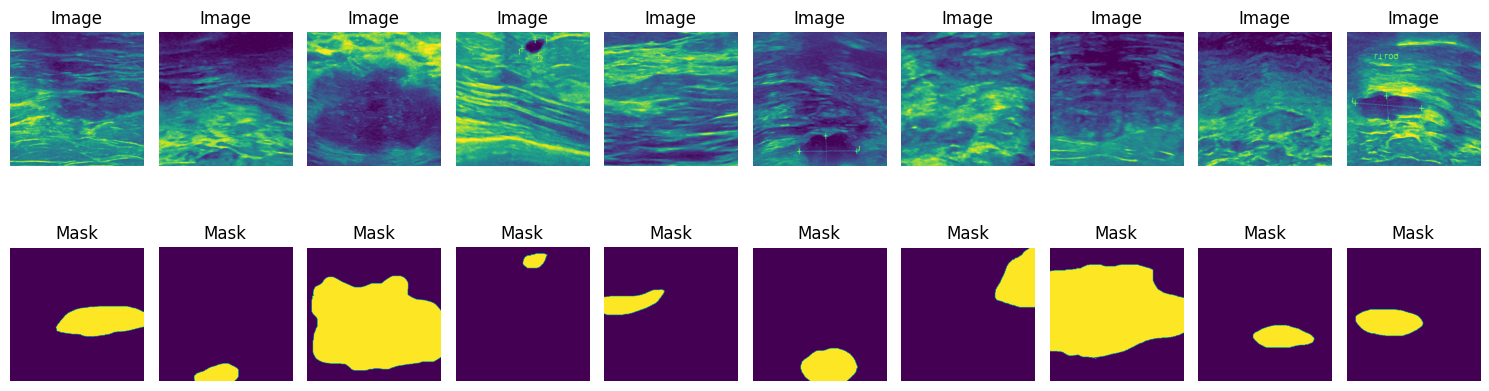

In [ ]:
# show how image looks like
import matplotlib.pyplot as plt
from torchvision import transforms

# Assuming your dataset provides a way to access individual samples by index
# Replace `get_sample(index)` with the actual method from your dataset
num_images_to_display = 10  # Change this according to your preference
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    sample = train_dataset[i]  # Get a sample from the dataset
    image, mask = sample  # Unpack the tuple

    image = image.squeeze().numpy()  # Remove batch dimension and convert to numpy array
    # image = (image * 0.5) + 0.5  # Unnormalize the image

    mask = mask.squeeze().numpy()  # Remove batch dimension and convert to numpy array
    # mask = (mask * 0.5) + 0.5  # Unnormalize the mask

    axes[0, i].imshow(image)  # Display the image
    axes[0, i].axis('off')
    axes[0, i].set_title('Image')

    axes[1, i].imshow(mask)  # Display the mask
    axes[1, i].axis('off')
    axes[1, i].set_title('Mask')

plt.tight_layout()
plt.show()

### Loss functions

In [ ]:
def dice_loss(y_pred, y_true):
    y_pred = torch.sigmoid(y_pred)
    # Flatten the predictions and ground truth
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Compute the intersection and union
    intersection = (y_true_flat * y_pred_flat).sum() + 1
    union = (y_true_flat).sum() + (y_pred_flat).sum() + 1

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union

    return dice_loss

def composite_loss(*losses):
    def loss(y_pred, y_true):
        return sum(loss(y_pred, y_true) for loss in losses)
    return loss

In [ ]:
# Evaluation functions

# percent of pixels that are accurately classified
def pixel_acc(pred_mask, true_mask):
    correct_pixels = (pred_mask == true_mask).sum().item()
    total_pixels = true_mask.numel()
    accuracy = correct_pixels / total_pixels

    return accuracy

def pixel_f1(pred_mask, true_mask):
    tp = (pred_mask * true_mask).sum().item()
    fp = (pred_mask * (1 - true_mask)).sum().item()
    fn = ((1 - pred_mask) * true_mask).sum().item()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if (precision + recall) == 0:
      return 0.0

    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# overlap between predicted bounding boxes and ground truth boxes
def calculate_iou(pred_mask, true_mask):
    intersection = torch.logical_and(true_mask, pred_mask).sum().item()
    union = torch.logical_or(true_mask, pred_mask).sum().item()
    iou = intersection / union if union != 0 else 0
    return iou

# similarity between a predicted segmentation mask and the ground truth segmentation mask
# Calculate Dice coefficient
def dice_coefficient(pred_mask, true_mask):
    intersection = torch.logical_and(true_mask, pred_mask).sum().item()
    # Check if denominator is not zero before division
    true_mask_sum = true_mask.sum().item()
    pred_mask_sum = pred_mask.sum().item()
    if true_mask_sum == 0 and pred_mask_sum == 0:
        dice = 1.0  # Set Dice coefficient to 1 if both masks are empty
    else:
        dice = 2 * intersection / (true_mask_sum + pred_mask_sum)
    return dice

### training

In [ ]:
model = UNET().to(device)
# loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = dice_loss
loss_fn = composite_loss(nn.BCEWithLogitsLoss(), dice_loss)
optimizer = torch.optim.Adam(model.parameters())

# metrics = dict()
# metrics["train_losses"] = []

optimizer.zero_grad()

# initialize lists to store evaluation metrics
train_losses = []
val_losses = []

# validation metrics
f1s = []
ious = []
dice_coefficients = []

# training metrics
tf1 = []
tiou = []
tdice = []

for epoch in range(200):
    train_loss = 0
    tf1_epoch = 0
    tiou_epoch = 0
    tdice_epoch = 0

    model.train()
    pbar = tqdm(train_dataloader)
    for batch in pbar:
        image, mask = batch
        image, mask = image.to(device), mask.to(device)
        pred_mask = model(image)
        loss = loss_fn(pred_mask, mask)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
          loss = loss.cpu().item()
          train_loss += loss

          pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
          tf1_epoch += pixel_f1(pred_mask, mask)
          tiou_epoch += calculate_iou(pred_mask, mask)
          tdice_epoch += dice_coefficient(pred_mask, mask)
          pbar.set_postfix(loss = loss)

    # compute average metrics for the epoch
    train_loss /= len(train_dataloader)
    tf1_epoch /= len(train_dataloader)
    tiou_epoch /= len(train_dataloader)
    tdice_epoch /= len(train_dataloader)

    # update lists
    train_losses.append(train_loss)
    tf1.append(tf1_epoch)
    tiou.append(tiou_epoch)
    tdice.append(tdice_epoch)

    # Calculate evaluation metrics
    val_loss = 0
    f1_epoch = 0
    iou_epoch = 0
    dice_epoch = 0

    model.eval()
    for batch in val_dataloader:
        image, mask = batch
        image, mask = image.to(device), mask.to(device)
        with torch.no_grad():
            pred_mask = model(image)
            val_loss += loss_fn(pred_mask, mask).detach().cpu().item()

            # calculate evaluation metrics
            pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
            f1_epoch += pixel_f1(pred_mask, mask)
            iou_epoch += calculate_iou(pred_mask, mask)
            dice_epoch += dice_coefficient(pred_mask, mask)

    # compute average metrics for the epoch
    val_loss /= len(val_dataloader)
    f1_epoch /= len(val_dataloader)
    iou_epoch /= len(val_dataloader)
    dice_epoch /= len(val_dataloader)

    # update lists
    val_losses.append(val_loss)
    f1s.append(f1_epoch)
    ious.append(iou_epoch)
    dice_coefficients.append(dice_epoch)

    ic(epoch, train_loss, val_loss, f1_epoch, iou_epoch, dice_epoch, tf1_epoch, tiou_epoch, tdice_epoch)

100%|██████████| 156/156 [00:17<00:00,  8.69it/s, loss=1.16]
ic| epoch: 0
    train_loss: 1.253363236402854
    val_loss: 1.3570568164189656
    f1_epoch: 0.2405967081175127
    iou_epoch: 0.13817003179703022
    dice_epoch: 0.24344472496372402
    tf1_epoch: 0.03280598810577286
    tiou_epoch: 0.019204206604256476
    tdice_epoch: 0.06072687211052822
100%|██████████| 156/156 [00:17<00:00,  8.68it/s, loss=1.27]
ic| epoch: 1
    train_loss: 1.1599180304851286
    val_loss: 1.4994718233744304
    f1_epoch: 0.22233536715168079
    iou_epoch: 0.12931291128330105
    dice_epoch: 0.22503947578371766
    tf1_epoch: 0.21473222049893442
    tiou_epoch: 0.10363272608529808
    tdice_epoch: 0.29344992754598664
100%|██████████| 156/156 [00:17<00:00,  8.68it/s, loss=1.22]
ic| epoch: 2
    train_loss: 1.1822704542905857
    val_loss: 1.5679911375045776
    f1_epoch: 0.2222163920790662
    iou_epoch: 0.12757434445235347
    dice_epoch: 0.22476989217752288
    tf1_epoch: 0.13051080298082196
    tiou_e

In [ ]:
print("Highest validation IOU: ", max(ious),
      " for epoch ", ious.index(max(ious))+1,
      " with training IOU: ", tiou[ious.index(max(ious))])

Highest validation IOU:  0.5817379239499907  for epoch  157  with training IOU:  0.34730092580816485


### Visualisation

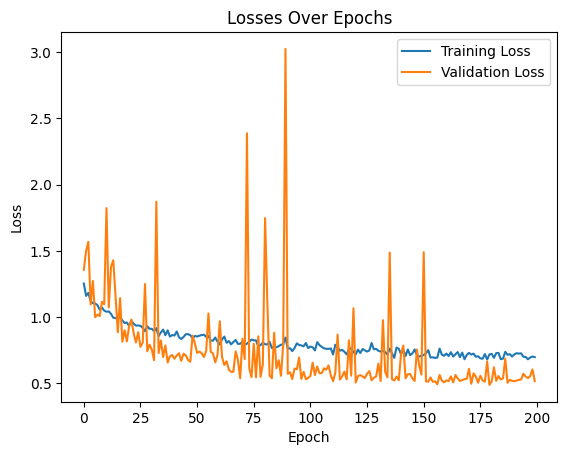

In [ ]:
# Plot losses
plt.plot([loss for loss in train_losses], label='Training Loss')
plt.plot([loss for loss in val_losses], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses Over Epochs')
plt.legend()
plt.show()

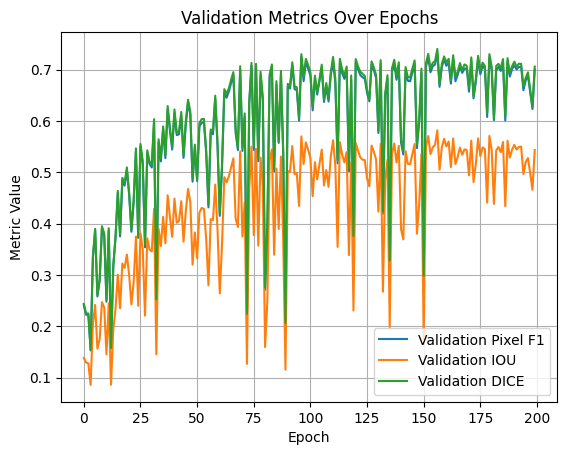

In [ ]:
# plot accuracy and evaluation metrics
plt.plot(f1s, label='Validation Pixel F1')
plt.plot(ious, label='Validation IOU')
plt.plot(dice_coefficients, label='Validation DICE')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

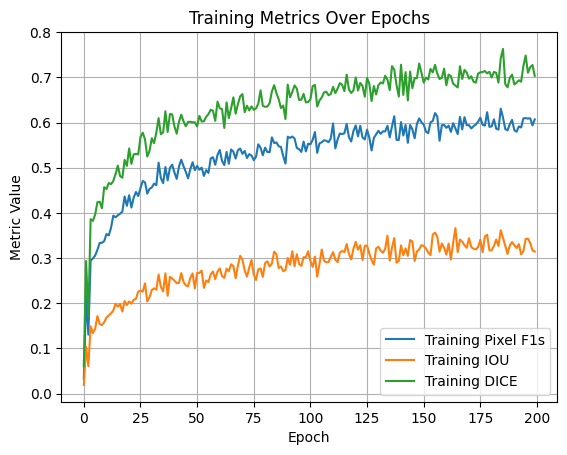

In [ ]:
# plot accuracy and evaluation metrics
plt.plot(tf1, label='Training Pixel F1s')
plt.plot(tiou, label='Training IOU')
plt.plot(tdice, label='Training DICE')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

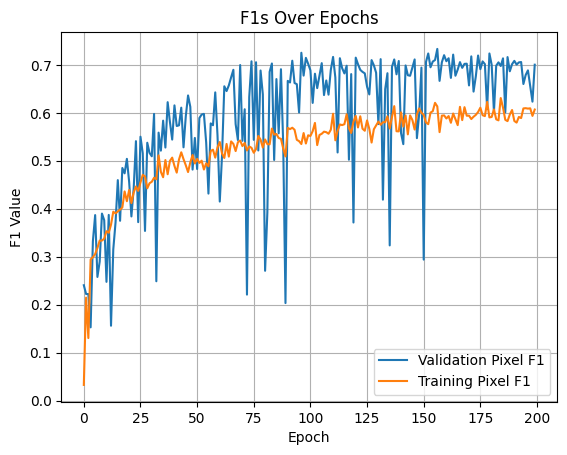

In [ ]:
# plot F1
plt.plot(f1s, label='Validation Pixel F1')
plt.plot(tf1, label='Training Pixel F1')

plt.xlabel('Epoch')
plt.ylabel('F1 Value')
plt.title('F1s Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

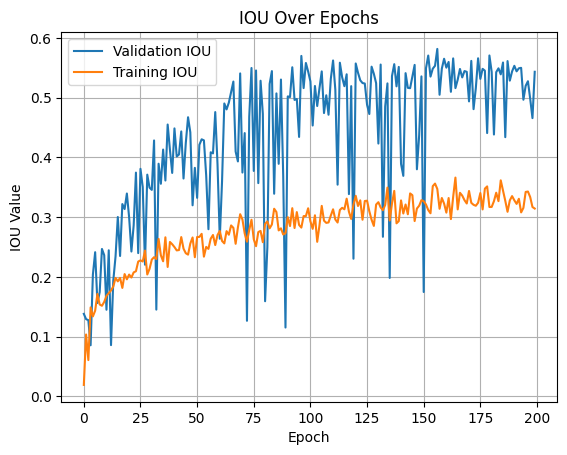

In [ ]:
# plot IOUs
plt.plot(ious, label='Validation IOU')
plt.plot(tiou, label='Training IOU')

plt.xlabel('Epoch')
plt.ylabel('IOU Value')
plt.title('IOU Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

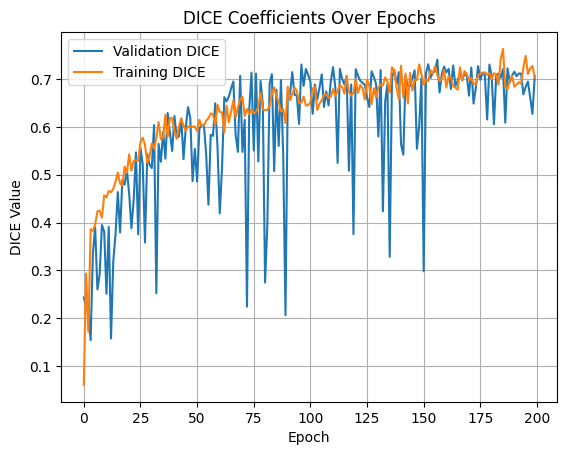

In [ ]:
# plot DICEs
plt.plot(dice_coefficients, label='Validation DICE')
plt.plot(tdice, label='Training DICE')

plt.xlabel('Epoch')
plt.ylabel('DICE Value')
plt.title('DICE Coefficients Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torchvision.transforms.functional as Func
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = Func.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for i in range(50):
    img, mask = val_dataset[i]
    model.eval()
    out = torch.sigmoid(model(img.to(device).unsqueeze(0)).squeeze())
    binary_out = (out > 0.5).float()  # Convert to binary mask
    show([img, out, binary_out, mask])

Output hidden; open in https://colab.research.google.com to view.

### Evaluation
- Calculating evaluation metrics on the test dataset

In [ ]:
# Evaluation loop
test_pixel_f1s = []
test_ious = []
test_dice_scores = []

model.eval()
for batch in test_dataloader:
    image, mask = batch
    image, mask = image.to(device), mask.to(device)
    with torch.no_grad():
        pred_mask = model(image)
        pred_mask_binary = (torch.sigmoid(pred_mask) > 0.5).float()

        # Calculate pixel f1
        pixel_f1_score = pixel_f1(pred_mask_binary, mask)
        test_pixel_f1s.append(pixel_f1_score)

        # Calculate IoU
        iou = calculate_iou(pred_mask_binary, mask)
        test_ious.append(iou)

        # Calculate Dice coefficient
        dice_score = dice_coefficient(pred_mask_binary, mask)
        test_dice_scores.append(dice_score)

avg_test_pixel_f1 = sum(test_pixel_f1s) / len(test_pixel_f1s)
avg_test_iou = sum(test_ious) / len(test_ious)
avg_test_dice_score = sum(test_dice_scores) / len(test_dice_scores)

print("Test Pixel F1:", avg_test_pixel_f1)
print("Average IoU on Test Dataset:", avg_test_iou)
print("Average Dice Coefficient on Test Dataset:", avg_test_dice_score)

Test Pixel F1: 0.6783902473003808
Average IoU on Test Dataset: 0.5247418363880215
Average Dice Coefficient on Test Dataset: 0.6835218094473774


### Save model to a file

In [ ]:
# save model using torch
torch.save(model, '/content/drive/MyDrive/50.039_DL_Project/saved_models/unet_512_200epochs.pth')
# torch.save(model.state_dict(), '/content/drive/MyDrive/50.039_DL_Project/saved_models/unet_512_params.pth')

In [ ]:
import pickle

In [ ]:
# also store all the lists for plotting

metrics_dict = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'f1s': f1s,
    'ious': ious,
    'dice_coefficients': dice_coefficients,
    'tf1': tf1,
    'tiou': tiou,
    'tdice': tdice,
}

save_topath = '/content/drive/MyDrive/50.039_DL_Project/saved_models/unet_200epochs_metricslist.pkl'

with open(save_topath, 'wb') as file:
    pickle.dump(metrics_dict, file)

# Later, you can read the file and access the lists as follows:

# # Deserialize and read the dictionary from the file
# with open(save_topath, 'rb') as file:
#     loaded_dict = pickle.load(file)

# train_losses = loaded_dict['train_losses']
# val_losses = loaded_dict['val_losses']
...

Ellipsis